# Load data & show OHLC

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/IEOR4571 Final Project/data/cleaned_USD_CAD_20030917_20251117.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df[['Open', 'High', 'Low', 'Close']]
df = df.sort_index()
df.head()


,Open,High,Low,Close
Date,,,,
2003-09-17,1.3667,1.3704,1.3636,1.3667
2003-09-18,1.3660,1.3685,1.3597,1.3615
2003-09-19,1.3620,1.3630,1.3457,1.3472
2003-09-22,1.3413,1.3553,1.3365,1.3542
2003-09-23,1.3549,1.3577,1.3458,1.3551


# Exponential Smoothing Functions

Exponential smoothing and basic helpers

In [ ]:
def exponential_smoothing(series, alpha):
    """
    Compute exponential smoothing for a price series.

    Parameters
    ----------
    series : pandas Series
        Input price series (e.g. FX closing prices).
    alpha : float
        Smoothing parameter, 0 < alpha < 1.
        Higher alpha -> more weight on recent observations (faster series).

    Returns
    -------
    pandas Series of smoothed values.
    """
    return series.ewm(alpha=alpha, adjust=False).mean()


def compute_basic_returns(data):
    """
    Add raw market returns (close-to-close) to the DataFrame.

    Parameters
    ----------
    data : pandas DataFrame
        Must contain a 'Close' column.

    Returns
    -------
    pandas DataFrame with 'market_return' column.
    """
    df = data.copy()
    df['market_return'] = df['Close'].pct_change()
    return df


# Full Trading Strategy (Long & Short Combined)

Build positions with crossover, buffer, deceleration

In [ ]:
# Trading signals... and position rules

def build_strategy(
    data,
    alpha,
    beta,
    buffer_x=0.0,
    use_deceleration=False,
    decel_threshold=0.0
):
    """
    Build a trading strategy based on two exponential smoothing series:
        ES_fast = ES(alpha)
        ES_slow = ES(beta)

    Trading logic (trend-following version):
        - Go long when ES_fast crosses above ES_slow (+ optional buffer_x).
        - Go short when ES_fast crosses below ES_slow (symmetric).
        - Optionally close positions when ES_slow starts to decelerate
          beyond a threshold (decel_threshold).

    Parameters
    ----------
    data : pandas DataFrame
        Must contain 'Close' prices.
    alpha : float
        Smoothing parameter for fast ES (0 < alpha < 1).
    beta : float
        Smoothing parameter for slow ES (alpha < beta < 1).
    buffer_x : float, optional
        Minimum distance between ES_fast and ES_slow to trigger a trade.
        For longs:  ES_fast > ES_slow + buffer_x
        For shorts: ES_fast < ES_slow - buffer_x
    use_deceleration : bool, optional
        If True, allow ES_slow deceleration to close positions.
    decel_threshold : float, optional
        Threshold on the first difference of ES_slow.
        Example:
            For long positions, if ΔES_slow = ES_slow[t] - ES_slow[t-1]
            falls below decel_threshold, we close the long.

    Returns
    -------
    pandas DataFrame with columns:
        ES_fast, ES_slow, position, market_return, strategy_return, cum_return
    """
    df = data.copy()

    # Compute exponential smoothing series
    df['ES_fast'] = exponential_smoothing(df['Close'], alpha)
    df['ES_slow'] = exponential_smoothing(df['Close'], beta)

    # Compute slope (first difference) of slow ES for deceleration rule
    df['ES_slow_diff'] = df['ES_slow'].diff()

    # Pre-compute crossover conditions (without applying the position yet)
    # Crossover upwards: fast crosses above slow
    cross_up = (
        (df['ES_fast'].shift(1) <= df['ES_slow'].shift(1)) &
        (df['ES_fast'] > df['ES_slow'] + buffer_x)
    )

    # Crossover downwards: fast crosses below slow
    cross_down = (
        (df['ES_fast'].shift(1) >= df['ES_slow'].shift(1)) &
        (df['ES_fast'] < df['ES_slow'] - buffer_x)
    )

    # building positions in a loop to correctly apply deceleration exits.
    position = []
    current_pos = 0  # 1 = long, -1 = short, 0 = flat

    for t in range(len(df)):
        if t == 0:
            # First observation: cannot trade yet
            position.append(0)
            continue

        # By default, keep previous position
        new_pos = current_pos

        # Check entry/flip signals first
        if cross_up.iloc[t]:
            new_pos = 1     # enter or switch to long
        elif cross_down.iloc[t]:
            new_pos = -1    # enter or switch to short

        # Apply deceleration exit rule if enabled
        if use_deceleration and t > 1:
            slow_diff = df['ES_slow_diff'].iloc[t]

            # For a long position: close if ES_slow change is too weak or negative
            if current_pos == 1 and slow_diff < decel_threshold:
                new_pos = 0  # exit long

            # For a short position: close if ES_slow starts rising too fast
            if current_pos == -1 and slow_diff > -decel_threshold:
                new_pos = 0  # exit short

        # Store and update state
        position.append(new_pos)
        current_pos = new_pos

    df['position'] = position


    df = compute_basic_returns(df)

    # Strategy return: apply yesterday's position to today's market return
    df['strategy_return'] = df['position'].shift(1) * df['market_return']

    # Cumulative return (starting from 1.0)
    df['cum_return'] = (1 + df['strategy_return'].fillna(0)).cumprod()

    return df


# (Q2) One-Side Strategies (Long-only / Short-only) & Parameter Search

Long-only vs Short-only Parameter Search



> Should α and β differ for long versus short positions?



In [ ]:
def build_strategy_one_side(data, alpha, beta, side="long"):
    """
    Build a strategy that only trades on one side of the market.

    Parameters
    ----------
    data : pandas DataFrame
        Must contain a 'Close' column.
    alpha : float
        Smoothing parameter for the fast ES (0 < alpha < 1).
    beta : float
        Smoothing parameter for the slow ES (alpha < beta < 1).
    side : {"long", "short"}
        "long"  -> only take long entries and close when an opposite crossover appears.
        "short" -> only take short entries and close when an opposite crossover appears.

    Trading logic
    -------------
    - We still compute ES_fast = ES(alpha) and ES_slow = ES(beta).
    - For side = "long":
        * Enter long when ES_fast crosses above ES_slow.
        * Exit the long when ES_fast crosses below ES_slow.
    - For side = "short":
        * Enter short when ES_fast crosses below ES_slow.
        * Exit the short when ES_fast crosses above ES_slow.

    Returns
    -------
    pandas DataFrame with columns:
        ES_fast, ES_slow, position, market_return, strategy_return, cum_return
    """
    df = data.copy()

    # Compute exponential smoothing series
    df['ES_fast'] = exponential_smoothing(df['Close'], alpha)
    df['ES_slow'] = exponential_smoothing(df['Close'], beta)

    # Crossover conditions (no buffer / deceleration here for clarity)
    cross_up = (df['ES_fast'].shift(1) <= df['ES_slow'].shift(1)) & \
               (df['ES_fast'] > df['ES_slow'])

    cross_down = (df['ES_fast'].shift(1) >= df['ES_slow'].shift(1)) & \
                 (df['ES_fast'] < df['ES_slow'])

    position = []
    current_pos = 0  # 1 = long, -1 = short, 0 = flat

    for t in range(len(df)):
        if t == 0:
            position.append(0)
            continue

        new_pos = current_pos

        if side == "long":
            # Only respond to long-side signals.
            if cross_up.iloc[t]:
                new_pos = 1       # enter long
            elif cross_down.iloc[t]:
                new_pos = 0       # exit long when opposite crossover appears

        elif side == "short":
            # Only respond to short-side signals.
            if cross_down.iloc[t]:
                new_pos = -1      # enter short
            elif cross_up.iloc[t]:
                new_pos = 0       # exit short when opposite crossover appears

        position.append(new_pos)
        current_pos = new_pos

    df['position'] = position

    # Compute returns as before
    df = compute_basic_returns(df)
    df['strategy_return'] = df['position'].shift(1) * df['market_return']
    df['cum_return'] = (1 + df['strategy_return'].fillna(0)).cumprod()

    return df


- Long-only grid search cell




In [ ]:
# is there an optimal (alpha, beta) for long-only trades?


alphas = np.arange(0.05, 0.55, 0.05)   # 0.05, 0.10, ..., 0.50
betas  = np.arange(0.10, 0.90, 0.10)   # 0.10, 0.20, ..., 0.80

long_side_results = []

for a in alphas:
    for b in betas:
        if a >= b:
            # keep the requirement alpha < beta
            continue

        strat_long = build_strategy_one_side(df, alpha=a, beta=b, side="long")
        perf_long = performance_summary(strat_long)

        long_side_results.append({
            "alpha": a,
            "beta": b,
            "total_return": perf_long["total_return"],
            "sharpe": perf_long["sharpe_ratio"],
            "hit_rate_days": perf_long["hit_rate"],
            "num_trades": perf_long["num_trades"]
        })

long_side_results = pd.DataFrame(long_side_results)
long_side_results.sort_values("sharpe", ascending=False).head()


,alpha,beta,total_return,sharpe,hit_rate_days,num_trades
25,0.20,0.6,0.573875,0.369601,0.254596,796
21,0.15,0.8,0.570003,0.368422,0.253729,856
17,0.15,0.4,0.557743,0.364474,0.249393,546
16,0.15,0.3,0.524277,0.347166,0.249220,474
35,0.30,0.4,0.508654,0.338400,0.254249,774


- Short-only grid search cell

In [ ]:
short_side_results = []

for a in alphas:
    for b in betas:
        if a >= b:
            continue

        strat_short = build_strategy_one_side(df, alpha=a, beta=b, side="short")
        perf_short = performance_summary(strat_short)

        short_side_results.append({
            "alpha": a,
            "beta": b,
            "total_return": perf_short["total_return"],
            "sharpe": perf_short["sharpe_ratio"],
            "hit_rate_days": perf_short["hit_rate"],
            "num_trades": perf_short["num_trades"]
        })

short_side_results = pd.DataFrame(short_side_results)
short_side_results.sort_values("sharpe", ascending=False).head()


,alpha,beta,total_return,sharpe,hit_rate_days,num_trades
25,0.20,0.6,0.398690,0.268759,0.250780,795
21,0.15,0.8,0.394754,0.266342,0.251474,855
17,0.15,0.4,0.382421,0.258877,0.254943,545
16,0.15,0.3,0.353253,0.244189,0.255463,473
35,0.30,0.4,0.340090,0.237790,0.250087,773


In [ ]:
best_long = long_side_results.sort_values("sharpe", ascending=False).iloc[0]
best_short = short_side_results.sort_values("sharpe", ascending=False).iloc[0]

print("Best long-only (alpha, beta): ", best_long["alpha"], best_long["beta"])
print("Best short-only (alpha, beta):", best_short["alpha"], best_short["beta"])


Best long-only (alpha, beta):  0.2 0.6
Best short-only (alpha, beta): 0.2 0.6


# Performance Measurement Functions


Performance metrics (overall + long/short)

In [ ]:
# Performance measurements

def performance_summary(df):
    """
    Compute basic performance statistics for a strategy.

    Parameters
    ----------
    df : pandas DataFrame
        Must contain 'strategy_return' and 'position' columns.

    Returns
    -------
    dict with performance metrics.
    """
    # Drop NaN at the beginning
    strat_ret = df['strategy_return'].dropna()

    total_return = df['cum_return'].iloc[-1] - 1
    avg_daily = strat_ret.mean()
    vol_daily = strat_ret.std()

    # Annualization assuming 252 trading days
    ann_return = (1 + avg_daily)**252 - 1
    ann_vol = vol_daily * np.sqrt(252)
    sharpe = ann_return / ann_vol if ann_vol != 0 else np.nan

    hit_rate = (strat_ret > 0).mean()

    # Number of trades: count changes in position (excluding zeros at start)
    pos = df['position'].fillna(0)
    trades = (pos != pos.shift(1)).sum()

    metrics = {
        "total_return": total_return,
        "avg_daily_return": avg_daily,
        "daily_volatility": vol_daily,
        "annualized_return": ann_return,
        "annualized_volatility": ann_vol,
        "sharpe_ratio": sharpe,
        "hit_rate": hit_rate,
        "num_trades": trades
    }
    return metrics


def long_short_performance(df):
    """
    Split performance between long-only and short-only days.

    Parameters
    ----------
    df : pandas DataFrame
        Must contain 'strategy_return' and 'position'.

    Returns
    -------
    Two dictionaries: long_metrics, short_metrics
    """
    strat_ret = df['strategy_return'].dropna()
    pos = df['position'].reindex(strat_ret.index)

    long_ret = strat_ret[pos > 0]
    short_ret = strat_ret[pos < 0]

    def _summary(ret):
        if len(ret) == 0:
            return {
                "avg_daily_return": np.nan,
                "hit_rate": np.nan,
                "num_days": 0
            }
        return {
            "avg_daily_return": ret.mean(),
            "hit_rate": (ret > 0).mean(),
            "num_days": len(ret)
        }

    long_metrics = _summary(long_ret)
    short_metrics = _summary(short_ret)

    return long_metrics, short_metrics


In [ ]:
# Trade-level performance: accuracy on a per-trade basis

def trade_level_stats(df):
    """
    Compute trade-level statistics:
        - number of trades
        - per-trade hit rate (proportion of profitable trades)
        - average trade return

    Parameters
    ----------
    df : pandas DataFrame
        Must contain 'position' and 'strategy_return'.

    Returns
    -------
    dict
        Dictionary containing trade-level performance statistics.
    """
    pos = df['position'].fillna(0)
    ret = df['strategy_return'].fillna(0)

    trades = []
    current_side = 0
    cum_ret = 0.0

    for t in range(len(df)):
        if current_side == 0:
            # Look for entry
            if pos.iloc[t] != 0:
                current_side = pos.iloc[t]
                cum_ret = 0.0
        else:
            # Accumulate return while in a trade
            cum_ret += ret.iloc[t]

            # Trade ends when position goes to zero or flips sign
            if pos.iloc[t] == 0 or pos.iloc[t] != current_side:
                trades.append(cum_ret)
                current_side = pos.iloc[t]
                cum_ret = 0.0

    trades = np.array(trades)
    if len(trades) == 0:
        return {
            "num_trades": 0,
            "hit_rate_trades": np.nan,
            "avg_trade_return": np.nan
        }

    return {
        "num_trades": len(trades),
        "hit_rate_trades": (trades > 0).mean(),
        "avg_trade_return": trades.mean()
    }


# （Q3/1）


In [ ]:
trade_stats_baseline = trade_level_stats(baseline_df)
trade_stats_baseline


{'num_trades': 349,
 'hit_rate_trades': np.float64(0.7277936962750716),
 'avg_trade_return': np.float64(0.001443286537835931)}

# Baseline Strategy Example

Run a baseline example (single α, β)

In [ ]:
alpha = 0.10
beta  = 0.25
buffer_x = 0.0
use_deceleration = False
decel_threshold = 0.0

baseline_df = build_strategy(
    df,
    alpha=alpha,
    beta=beta,
    buffer_x=buffer_x,
    use_deceleration=use_deceleration,
    decel_threshold=decel_threshold
)

baseline_df.tail()


,Open,High,Low,Close,ES_fast,ES_slow,ES_slow_diff,position,market_return,strategy_return,cum_return
Date,,,,,,,,,,,
2025-11-11,1.4026,1.4040,1.4003,1.4025,1.402190,1.404970,-0.000823,-1,-0.001353,0.001353,1.516472
2025-11-12,1.4017,1.4021,1.3994,1.4016,1.402131,1.404128,-0.000843,-1,-0.000642,0.000642,1.517445
2025-11-13,1.4009,1.4016,1.3985,1.4009,1.402008,1.403321,-0.000807,-1,-0.000499,0.000499,1.518203
2025-11-14,1.4036,1.4045,1.4015,1.4036,1.402167,1.403391,0.000070,-1,0.001927,-0.001927,1.515276
2025-11-17,1.4022,1.4041,1.4016,1.4018,1.402130,1.402993,-0.000398,-1,-0.001282,0.001282,1.517220


Plot price + ES and equity curve

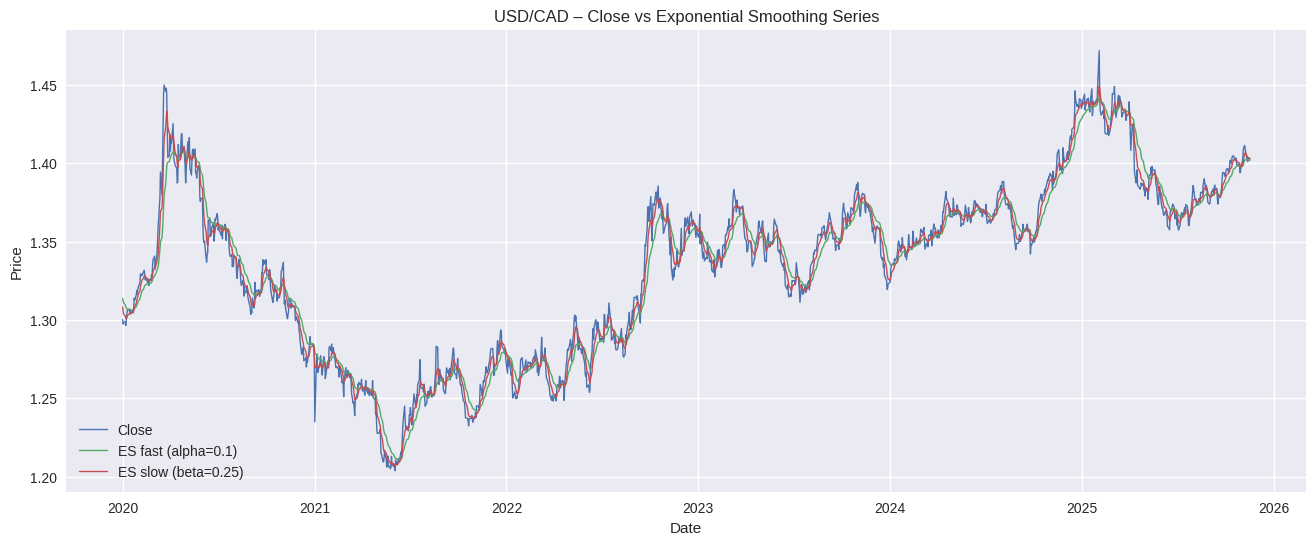

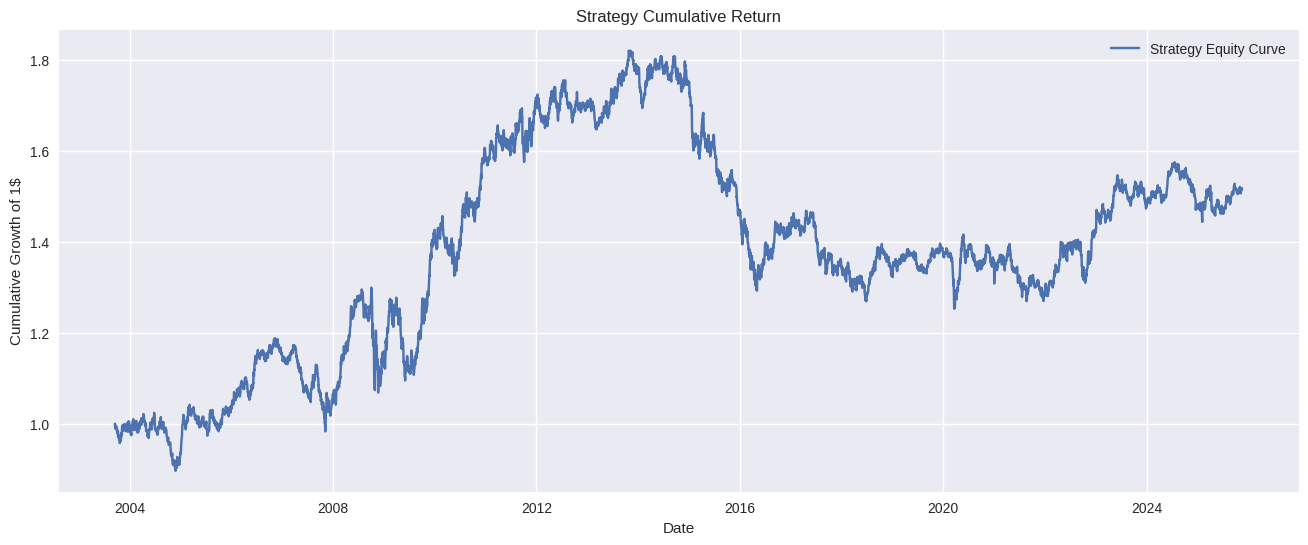

In [ ]:
# Choose a sub-period for clearer plotting (last 3 years)
plot_start = '2020-01-01'
sub = baseline_df[baseline_df.index >= plot_start]

# 1) Price and ES series
plt.figure(figsize=(16,6))
plt.plot(sub.index, sub['Close'], label='Close', linewidth=1)
plt.plot(sub.index, sub['ES_fast'], label=f'ES fast (alpha={alpha})', linewidth=1)
plt.plot(sub.index, sub['ES_slow'], label=f'ES slow (beta={beta})', linewidth=1)
plt.title("USD/CAD – Close vs Exponential Smoothing Series")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# 2) Strategy cumulative return
plt.figure(figsize=(16,6))
plt.plot(baseline_df.index, baseline_df['cum_return'], label='Strategy Equity Curve')
plt.title("Strategy Cumulative Return")
plt.xlabel("Date")
plt.ylabel("Cumulative Growth of 1$")
plt.legend()
plt.show()


# (Q3/2)

Print performance summary for baseline

In [ ]:
metrics = performance_summary(baseline_df)
long_metrics, short_metrics = long_short_performance(baseline_df)

print("=== Overall Strategy Performance ===")
for k, v in metrics.items():
    print(f"{k:25s}: {v: .6f}")

print("\n=== Long-only Days Performance ===")
for k, v in long_metrics.items():
    print(f"{k:25s}: {v: .6f}")

print("\n=== Short-only Days Performance ===")
for k, v in short_metrics.items():
    print(f"{k:25s}: {v: .6f}")


=== Overall Strategy Performance ===
total_return             :  0.517220
avg_daily_return         :  0.000087
daily_volatility         :  0.005404
annualized_return        :  0.022138
annualized_volatility    :  0.085785
sharpe_ratio             :  0.258065
hit_rate                 :  0.496185
num_trades               :  351.000000

=== Long-only Days Performance ===
avg_daily_return         :  0.000105
hit_rate                 :  0.496847
num_days                 :  2854.000000

=== Short-only Days Performance ===
avg_daily_return         :  0.000069
hit_rate                 :  0.495536
num_days                 :  2912.000000


# (Q1) Global Parameter Search for (α, β)

Grid search over α, β (find “best” pair)


>  Is there an optimal combination of α and β?




In [ ]:
alphas = np.arange(0.05, 0.55, 0.05)   # 0.05, 0.10, ..., 0.50
betas  = np.arange(0.10, 0.90, 0.10)   # 0.10, 0.20, ..., 0.80

results = []

for a in alphas:
    for b in betas:
        if a >= b:
            # Enforce alpha < beta as required by the assignment
            continue
        strat_df = build_strategy(df, alpha=a, beta=b)
        perf = performance_summary(strat_df)
        long_perf, short_perf = long_short_performance(strat_df)

        results.append({
            "alpha": a,
            "beta": b,
            "total_return": perf["total_return"],
            "sharpe": perf["sharpe_ratio"],
            "hit_rate": perf["hit_rate"],
            "num_trades": perf["num_trades"],
            "long_hit_rate": long_perf["hit_rate"],
            "short_hit_rate": short_perf["hit_rate"]
        })

grid_results = pd.DataFrame(results)
grid_results.sort_values("sharpe", ascending=False).head()


,alpha,beta,total_return,sharpe,hit_rate,num_trades,long_hit_rate,short_hit_rate
25,0.20,0.6,1.201363,0.453577,0.505376,796,0.502580,0.508220
21,0.15,0.8,1.189768,0.450778,0.505203,856,0.505002,0.505406
17,0.15,0.4,1.153456,0.441915,0.504336,546,0.503852,0.504811
16,0.15,0.3,1.062732,0.419157,0.504683,474,0.503330,0.506008
35,0.30,0.4,1.021732,0.408573,0.504336,774,0.501718,0.507003


In [ ]:
best_row = grid_results.sort_values("sharpe", ascending=False).iloc[0]
best_alpha = best_row["alpha"]
best_beta = best_row["beta"]

print("Best alpha:", best_alpha)
print("Best beta:", best_beta)


Best alpha: 0.2
Best beta: 0.6


Heatmap of performance

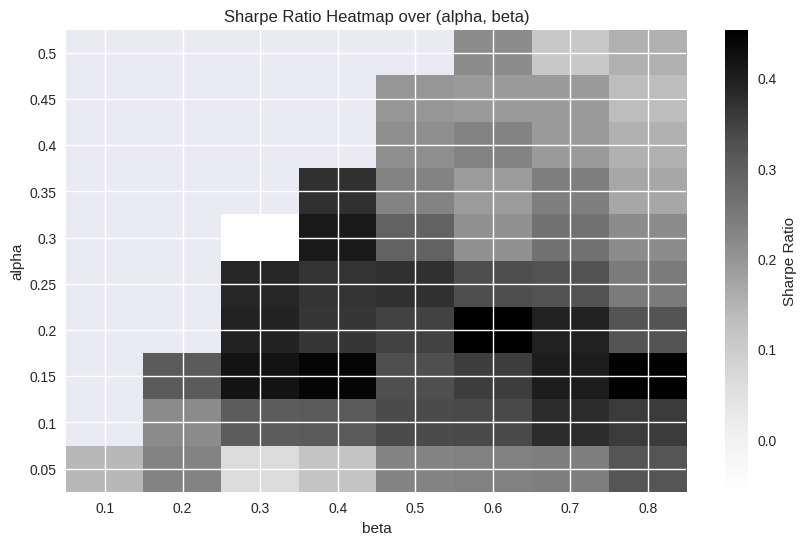

In [ ]:
# Sharpe ratio
pivot_sharpe = grid_results.pivot(index='alpha', columns='beta', values='sharpe')

plt.figure(figsize=(10,6))
plt.imshow(pivot_sharpe, origin='lower', aspect='auto')
plt.colorbar(label='Sharpe Ratio')
plt.xticks(range(len(pivot_sharpe.columns)), pivot_sharpe.columns.round(2))
plt.yticks(range(len(pivot_sharpe.index)), pivot_sharpe.index.round(2))
plt.xlabel('beta')
plt.ylabel('alpha')
plt.title('Sharpe Ratio Heatmap over (alpha, beta)')
plt.show()


# (Q5) Buffer-x Experiment


> Should one go long only if ES(α)+x < ES(β)? If so, what should x be?



In [ ]:
# Fix alpha and beta near the best combination from grid_results
best_row = grid_results.sort_values("sharpe", ascending=False).iloc[0]
best_alpha = best_row["alpha"]
best_beta  = best_row["beta"]

print(f"Using best (alpha, beta) from grid search: ({best_alpha}, {best_beta})")

buffer_values = [0.0, 0.0002, 0.0005, 0.0010]

buffer_results = []

for x in buffer_values:
    strat_df = build_strategy(df, alpha=best_alpha, beta=best_beta, buffer_x=x)
    perf = performance_summary(strat_df)
    buffer_results.append({
        "buffer_x": x,
        "total_return": perf["total_return"],
        "sharpe": perf["sharpe_ratio"],
        "hit_rate": perf["hit_rate"],
        "num_trades": perf["num_trades"]
    })

buffer_results_df = pd.DataFrame(buffer_results)
buffer_results_df


Using best (alpha, beta) from grid search: (0.2, 0.6)


,buffer_x,total_return,sharpe,hit_rate,num_trades
0,0.0000,1.201363,0.453577,0.505376,796
1,0.0002,0.661356,0.305445,0.503469,656
2,0.0005,0.699061,0.317199,0.504683,529
3,0.0010,0.161870,0.119943,0.500520,356


In [ ]:
# Build strategy using best (alpha, beta) from the grid search
strat_best = build_strategy(
    df,
    alpha=best_alpha,
    beta=best_beta
)

# Trade-level statistics for the best (alpha, beta)
trade_stats_best = trade_level_stats(strat_best)
trade_stats_best


{'num_trades': 794,
 'hit_rate_trades': np.float64(0.7355163727959698),
 'avg_trade_return': np.float64(0.0011004407258501253)}

Plot effect of buffer x on performance:


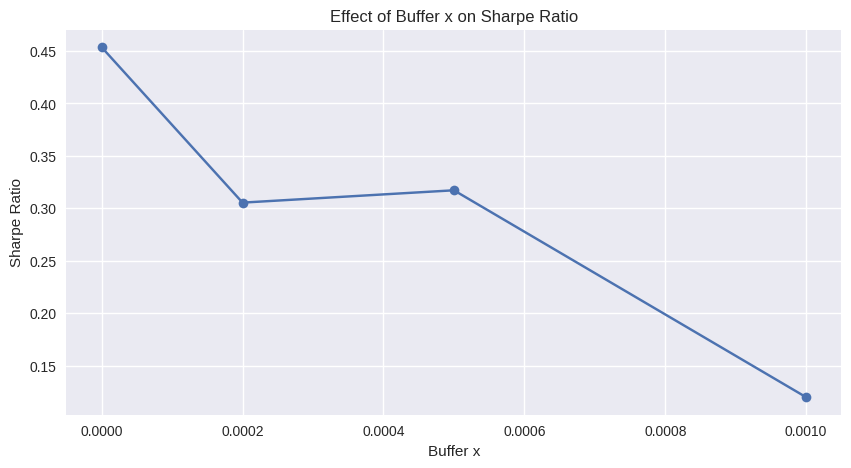

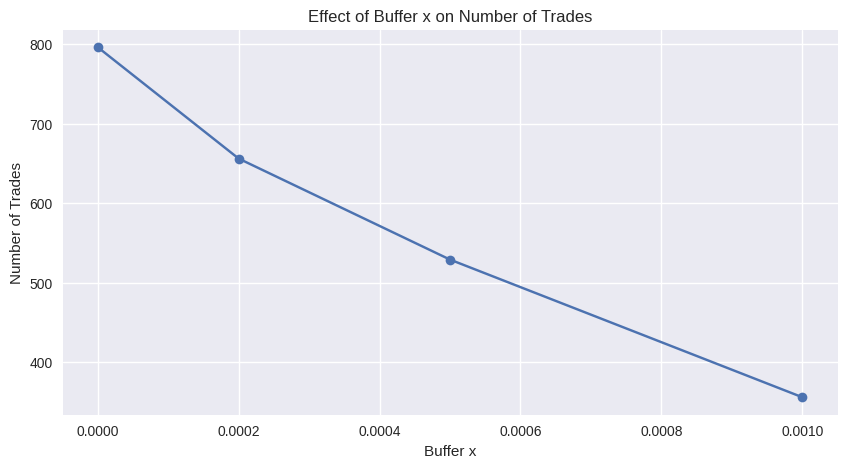

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(buffer_results_df['buffer_x'], buffer_results_df['sharpe'], marker='o')
plt.title("Effect of Buffer x on Sharpe Ratio")
plt.xlabel("Buffer x")
plt.ylabel("Sharpe Ratio")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(buffer_results_df['buffer_x'], buffer_results_df['num_trades'], marker='o')
plt.title("Effect of Buffer x on Number of Trades")
plt.xlabel("Buffer x")
plt.ylabel("Number of Trades")
plt.show()


# (Q4) Deceleration Exit Experiment



> When should a long position be closed? For example, should it be closed when ES(β) starts to decelerate—and at what rate?




In [ ]:
decel_thresholds = [0.0, 0.00005, 0.0001, 0.0002]

decel_results = []

for thr in decel_thresholds:
    strat_df = build_strategy(
        df,
        alpha=best_alpha,
        beta=best_beta,
        buffer_x=0.0,
        use_deceleration=True,
        decel_threshold=thr
    )
    perf = performance_summary(strat_df)
    decel_results.append({
        "decel_threshold": thr,
        "total_return": perf["total_return"],
        "sharpe": perf["sharpe_ratio"],
        "hit_rate": perf["hit_rate"],
        "num_trades": perf["num_trades"]
    })

decel_results_df = pd.DataFrame(decel_results)
decel_results_df


,decel_threshold,total_return,sharpe,hit_rate,num_trades
0,0.00000,0.048250,0.078894,0.081686,1398
1,0.00005,0.032628,0.059113,0.080819,1402
2,0.00010,0.032322,0.058844,0.080645,1403
3,0.00020,0.037306,0.065296,0.080298,1405


Plot

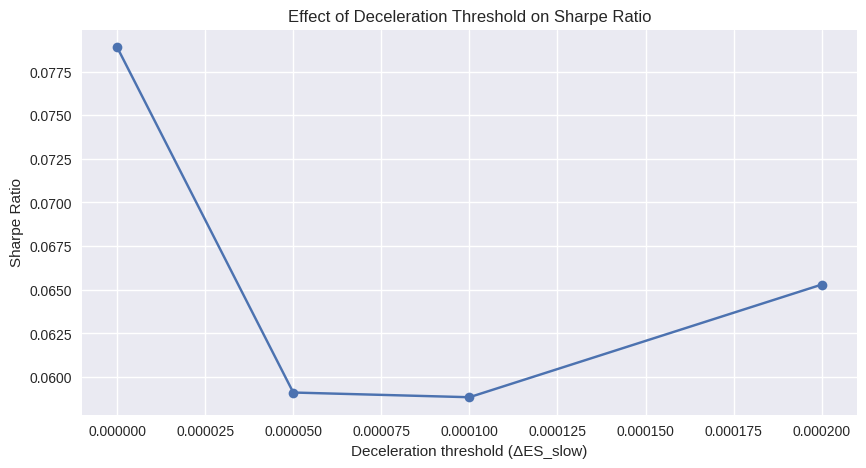

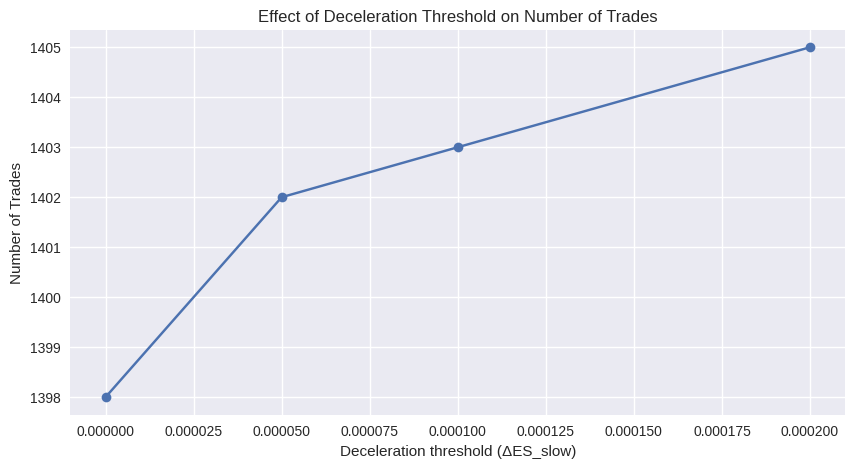

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(decel_results_df['decel_threshold'], decel_results_df['sharpe'], marker='o')
plt.title("Effect of Deceleration Threshold on Sharpe Ratio")
plt.xlabel("Deceleration threshold (ΔES_slow)")
plt.ylabel("Sharpe Ratio")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(decel_results_df['decel_threshold'], decel_results_df['num_trades'], marker='o')
plt.title("Effect of Deceleration Threshold on Number of Trades")
plt.xlabel("Deceleration threshold (ΔES_slow)")
plt.ylabel("Number of Trades")
plt.show()


# Final Summary Table

In [ ]:
summary_rows = []

# 1) Baseline: original (alpha=0.10, beta=0.25), no buffer, no deceleration
strat_baseline = build_strategy(
    df,
    alpha=0.10,
    beta=0.25,
    buffer_x=0.0,
    use_deceleration=False,
    decel_threshold=0.0
)
perf_baseline = performance_summary(strat_baseline)
summary_rows.append({
    "config": "baseline (alpha=0.10, beta=0.25)",
    **perf_baseline
})

# 2) Best buffer (max Sharpe at fixed best_alpha, best_beta)
best_buffer_row = buffer_results_df.sort_values("sharpe", ascending=False).iloc[0]
strat_buffer = build_strategy(
    df,
    alpha=best_alpha,
    beta=best_beta,
    buffer_x=best_buffer_row["buffer_x"]
)
perf_buffer = performance_summary(strat_buffer)
summary_rows.append({
    "config": f"best buffer_x={best_buffer_row['buffer_x']}",
    **perf_buffer
})

# 3) Best deceleration threshold (max Sharpe)
best_decel_row = decel_results_df.sort_values("sharpe", ascending=False).iloc[0]
strat_decel = build_strategy(
    df,
    alpha=best_alpha,
    beta=best_beta,
    buffer_x=0.0,
    use_deceleration=True,
    decel_threshold=best_decel_row["decel_threshold"]
)
perf_decel = performance_summary(strat_decel)
summary_rows.append({
    "config": f"best decel_thr={best_decel_row['decel_threshold']}",
    **perf_decel
})

final_summary = pd.DataFrame(summary_rows)
final_summary


,config,total_return,avg_daily_return,daily_volatility,annualized_return,annualized_volatility,sharpe_ratio,hit_rate,num_trades
0,"baseline (alpha=0.10, beta=0.25)",0.517220,0.000087,0.005404,0.022138,0.085785,0.258065,0.496185,351
1,best buffer_x=0.0,1.201363,0.000151,0.005403,0.038900,0.085762,0.453577,0.505376,796
2,best decel_thr=0.0,0.048250,0.000010,0.002085,0.002611,0.033099,0.078894,0.081686,1398
